In [1]:
import pandas as pd


proteome = pd.read_csv("../data/human_proteome.gz")
proteome["trivname"] = proteome["trivname"].apply(lambda x: x.split("_")[0])
data = pd.read_csv("../data/enzymes/processed.csv")
design = pd.read_csv("../data/enzymes/design.csv")
data.head(3)

,Protein Accession,Peptide,cht1,cht2,cht3,cht4,cht5,cht6,cht7,cht8,...,trp1,trp2,trp3,trp4,trp5,trp6,trp7,trp8,trp9,trp10
0,AHNK,SKGHYEVTGSDDETGKLQGSGVSLASK,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,1,1,1,1
1,AHNK,HELTEISNVDVETQSGK,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,AHNK,IKGDVPSVGLEGPDVDLQGPEAK,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [2]:
proteins = pd.read_csv("../data/enzymes/proteins.csv")

def shorten_histones(val : str):
    if val.startswith("H2"):
        return val[0:3]
    if val.startswith("H3"):
        return "H3"
    if val.startswith("CALM"):
        return "CALM"
    else:
        return val
    
proteins["Accession"] = proteins["Accession"].apply(lambda x: x.split("|")[1].split("_")[0])
proteins["short"] = proteins["Accession"].apply(lambda x: shorten_histones(x))
proteins.drop_duplicates("short", inplace=True)
proteins = proteins[proteins["#Peptides"] > 50]

proteins["pep per mass"] = proteins["#Peptides"] / proteins["Avg. Mass"] 
proteins = proteins.sort_values("pep per mass", ascending=False)["Accession"][0:20]
proteins

4      H2B1M
33     H2A1J
64        H4
113     CH10
7       ACTB
1       CH60
182      H32
22     ANXA2
134     RL40
69       H15
15      ATPB
16     ANXA1
25       G3P
83     CALM2
504    S10A6
42      ACTC
43      ACTA
8       ROA2
133    RS27A
72       H14
Name: Accession, dtype: object

In [3]:
import numpy as np


data = data[data["Protein Accession"].isin(proteins)]
samples = design["sample"]
data_dict = {}  # sample: {protein: {peptide:amount}}

for sample in samples:
    protein_dict = {}
    for protein in data["Protein Accession"].unique():
        sample_data = (
            data[["Protein Accession", "Peptide", sample]]
            .replace(0, np.nan)
            .dropna(subset=[sample])
        )
        sample_data = sample_data[sample_data["Protein Accession"] == protein]
        peptide_dict = {}
        # insert the original protein sequence
        try:
            protein_sequence = proteome[proteome["trivname"].isin([f"{protein}_HUMAN", protein])][
                "seq"
            ].values[0]
        except:
            print(protein)
            continue
        peptide_dict[protein_sequence] = (
            1  # probably want to replace this with some reasonable number
        )
        for i, row in sample_data.iterrows():
            peptide = row["Peptide"]
            abundance = row[sample]
            peptide_dict[peptide] = abundance
        protein_dict[protein] = peptide_dict
    data_dict[sample] = protein_dict
data_dict

{'cht1': {'CH60': {'MLRLPTVFRQMRPVSRVLAPHLTRAYAKDVKFGADARALMLQGVDLLADAVAVTMGPKGRTVIIEQSWGSPKVTKDGVTVAKSIDLKDKYKNIGAKLVQDVANNTNEEAGDGTTTATVLARSIAKEGFEKISKGANPVEIRRGVMLAVDAVIAELKKQSKPVTTPEEIAQVATISANGDKEIGNIISDAMKKVGRKGVITVKDGKTLNDELEIIEGMKFDRGYISPYFINTSKGQKCEFQDAYVLLSEKKISSIQSIVPALEIANAHRKPLVIIAEDVDGEALSTLVLNRLKVGLQVVAVKAPGFGDNRKNQLKDMAIATGGAVFGEEGLTLNLEDVQPHDLGKVGEVIVTKDDAMLLKGKGDKAQIEKRIQEIIEQLDVTTSEYEKEKLNERLAKLSDGVAVLKVGGTSDVEVNEKKDRVTDALNATRAAVEEGIVLGGGCALLRCIPALDSLTPANEDQKIGIEIIKRTLKIPAMTIAKNAGVEGSLIVEKIMQSSSEVGYDAMAGDFVNMVEKGIIDPTKVVRTALLDAAGVASLLTTAEVVVTEIPKEEKDPGMGAMGGMGGGMGGGMF': 1,
   'SEKKISSIQSIVPALEIANAH': 1.0,
   'VLLSEKKISSIQSIVPALEIANAH': 1.0,
   'KVGGTSDVEVNEKKDRVTDAL': 2.0,
   'SLTPANEDQKIGIEIIKRTL': 2.0,
   'DLGKVGEVIVTKDDAMLL': 1.0,
   'KDGVTVAKSIDLKDKY': 1.0,
   'VTKDGVTVAKSIDLKDKY': 1.0,
   'LSEKKISSIQSIVPALEIANAH': 1.0,
   'DLGKVGEVIVTKDDAML': 1.0,
   'KKQSKPVTTPEEIAQVA': 2.0,
   'KVGGTSDVEVNEKKDRVTD': 1.0,
   'VQDVANNTNEEAGDGTTTATVL': 2.0,
   'VIIAEDVDGEALSTL': 

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


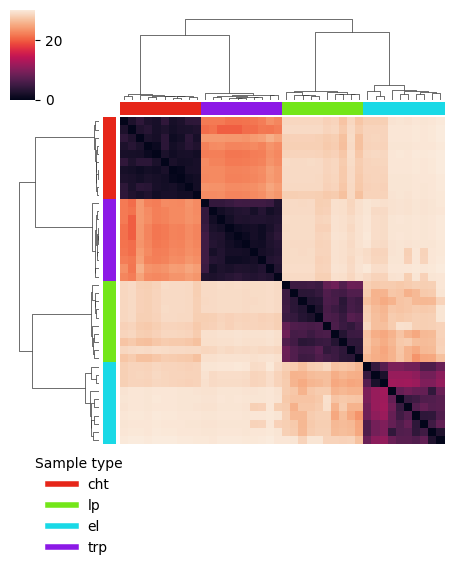

In [4]:
from disassembly.util import KL
from disassembly.estimate_parameters import compare

# data_dict  sample:protein:peptides

protein = "H4"

comparisons = {}
for i in data_dict.keys():
    if protein in data_dict[i].keys():
        peptidome_comp_1 = data_dict[i][protein]
        comparisons[i] = {}
        for j in data_dict.keys():
            if protein in data_dict[j].keys():
                peptidome_comp_2 = data_dict[j][protein]
                p, q = compare(peptidome_comp_1, peptidome_comp_2)
                err = KL(p, q) + KL(q, p)
                comparisons[i][j] = err

import pandas as pd

comps_df = pd.DataFrame(comparisons)

import seaborn as sns
from matplotlib.lines import Line2D

labels = design["group"]
lut = dict(zip(set(labels), sns.hls_palette(len(set(labels)), l=0.5, s=0.8)))
row_colors = design["group"].map(lut)

g = sns.clustermap(
    comps_df,
    figsize=(5, 5),
    row_colors=row_colors.to_numpy(),
    col_colors=row_colors.to_numpy(),
)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
legend_elements = [
    Line2D([0], [0], color=c, lw=4, label=l) for l, c in zip(lut.keys(), lut.values())
]
g.ax_heatmap.legend(
    frameon=False,
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(-0.3, 0),
    title="Sample type",
)

In [64]:
from disassembly.estimate_weights_gd import WeightEstimatorGD
from disassembly.disassembly import get_disassembly_indexes_mc, get_disassembly

results = {}  # dict of sample: protein_disassembly
wegd = WeightEstimatorGD(lr=.1, n_iterations=250)
n_pep = {}
average_di = {}
spc = {}

for sample, protein_dict in data_dict.items():
    print(f"\n ---{sample}--- \n")
    protein_disassembly = {}  # dict of protein: disassembly
    protein_n_pep = {}
    protein_di = {}
    protein_spc = {}
    for protein, peptidome in protein_dict.items():
        graph = wegd.run(peptidome, verbose=True)
        di = get_disassembly_indexes_mc(graph, N_particles=10000)
        disassembly = get_disassembly(peptidome, di, exp=True)
        protein_disassembly[protein] = disassembly
        protein_n_pep[protein] = len(peptidome.values())
        protein_di[protein] = np.mean(list(di.values()))
        protein_spc[protein] = sum(peptidome.values())
    results[sample] = protein_disassembly
    n_pep[sample] = protein_n_pep
    average_di[sample] = protein_di
    spc[sample] = protein_spc


 ---cht1--- 

 249 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 96 | 
 Averaged DI: 1.70
 249 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 190 | 
 Averaged DI: 2.12
 249 / 250 | 0.02, kl: 0.02, reg: 0.00  | nz: 122 | 
 Averaged DI: 1.78
 249 / 250 | 0.03, kl: 0.03, reg: 0.00  | nz: 64 | 
 Averaged DI: 1.39
 202 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 37 | 
 Averaged DI: 1.29
 177 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 47 | 
 Averaged DI: 1.52
 147 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 51 | 
 Averaged DI: 1.50
 249 / 250 | 0.03, kl: 0.03, reg: 0.00  | nz: 120 | 
 Averaged DI: 1.85
 249 / 250 | 0.02, kl: 0.02, reg: 0.00  | nz: 92 | 
 Averaged DI: 1.83
 74 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 66 | 
 Averaged DI: 1.91
 73 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 32 | 
 Averaged DI: 1.46
 44 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 18 | 
 Averaged DI: 1.52
 48 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 18 | 
 Averaged DI: 1.59
 43 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 18 | 
 Averaged DI

In [65]:
n_pep_df = pd.DataFrame(n_pep).stack().reset_index().rename(columns={"level_0":"protein", "level_1":"sample", 0:"n_pep"})
results_df = pd.DataFrame(results).stack().reset_index().rename(columns={"level_0":"protein", "level_1":"sample", 0:"d"})
average_di_df = pd.DataFrame(average_di).stack().reset_index().rename(columns={"level_0":"protein", "level_1":"sample", 0:"di"})
average_di_df.head(3)

,protein,sample,di
0,CH60,cht1,1.697250
1,CH60,cht2,1.618437
2,CH60,cht3,1.736362


In [104]:
n_pep_df = pd.DataFrame(n_pep).stack().reset_index().rename(columns={"level_0":"protein", "level_1":"sample", 0:"npep"})
results_df = pd.DataFrame(results).stack().reset_index().rename(columns={"level_0":"protein", "level_1":"sample", 0:"d"})
results_df = results_df.merge(n_pep_df).merge(design).merge(average_di_df)
results_df["d/npep"] = results_df["d"] / results_df["npep"]
results_df["di/npep"] = results_df["di"] / results_df["npep"]

<Axes: xlabel='npep', ylabel='d/npep'>

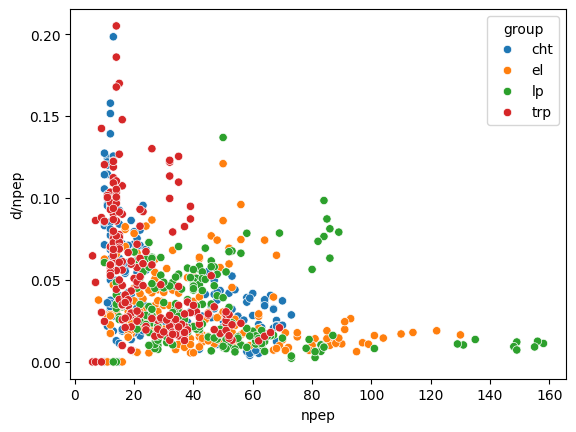

In [158]:
sns.scatterplot(results_df, x="npep", y="d/npep", hue="group")

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3398: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3398: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3398: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3398: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


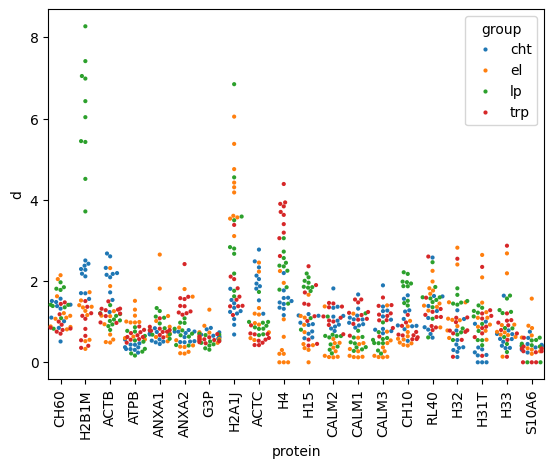

In [115]:
import matplotlib.pyplot as plt
sns.swarmplot(
    results_df, x="protein", y="d", hue="group", s= 3
)
plt.xticks(rotation=90)
plt.show()

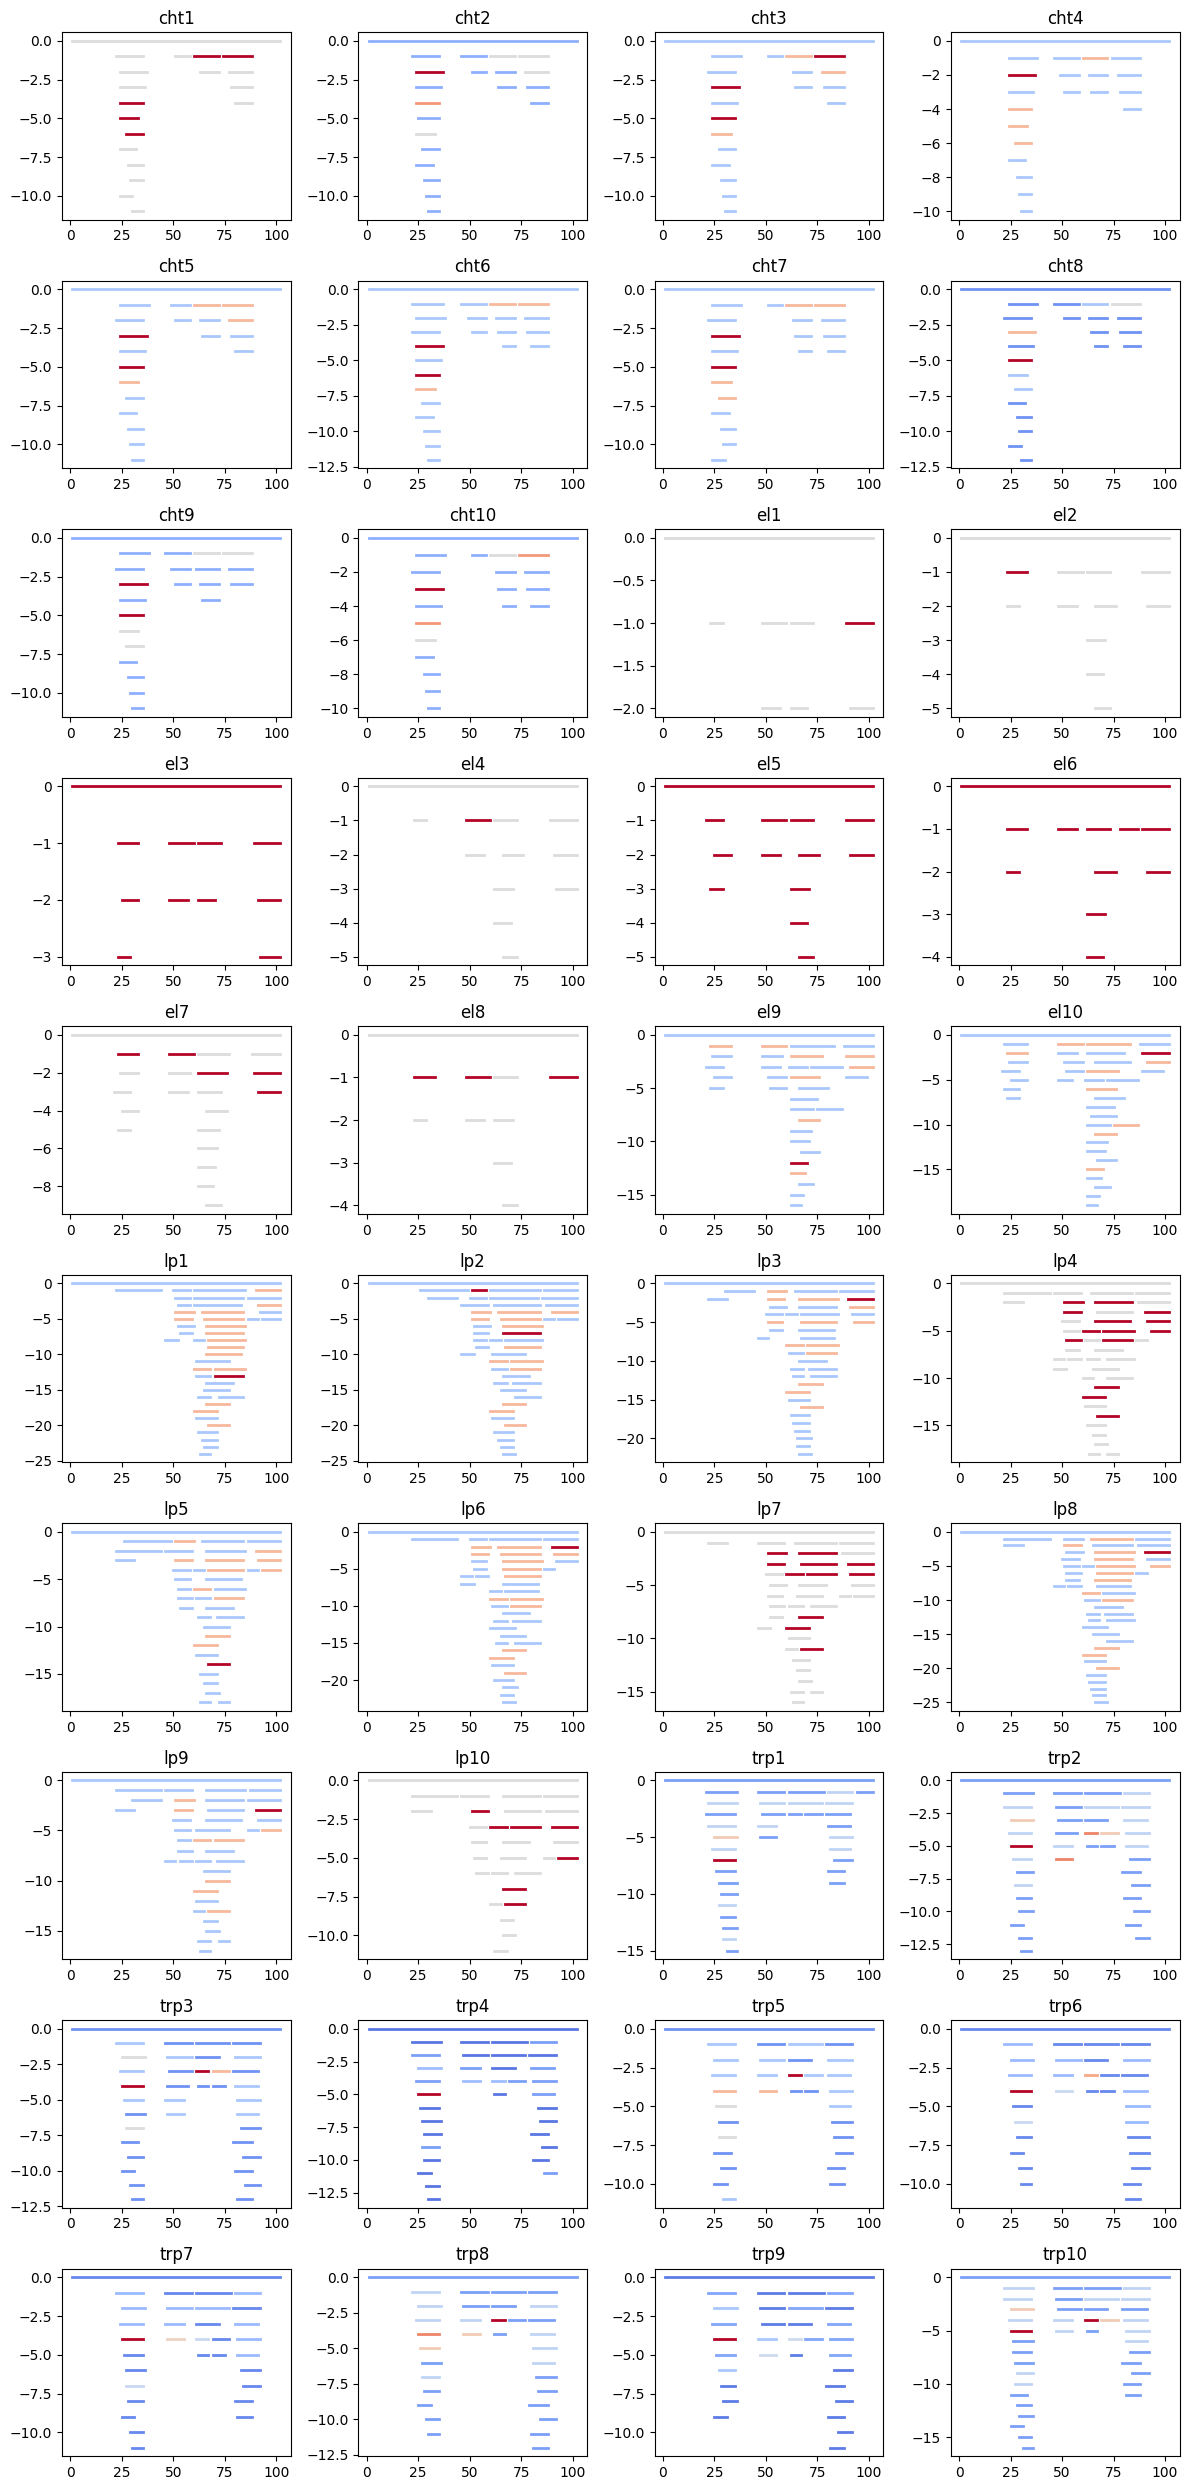

In [5]:
from disassembly.util import plot_peptidome
import matplotlib.pyplot as plt

fig, axs = plt.subplots(
    10,
    4,
    figsize=(12, 25),
)
for i, ax in zip(range(len(samples)), axs.ravel()):

    ax.set_title(f"{samples[i]}, d={results[samples[i]][protein]:.2f}")

    plot_peptidome(
        proteome[proteome["trivname"] == protein]["seq"].values[0],
        data_dict[samples[i]][protein],
        ax,
    )
plt.tight_layout()

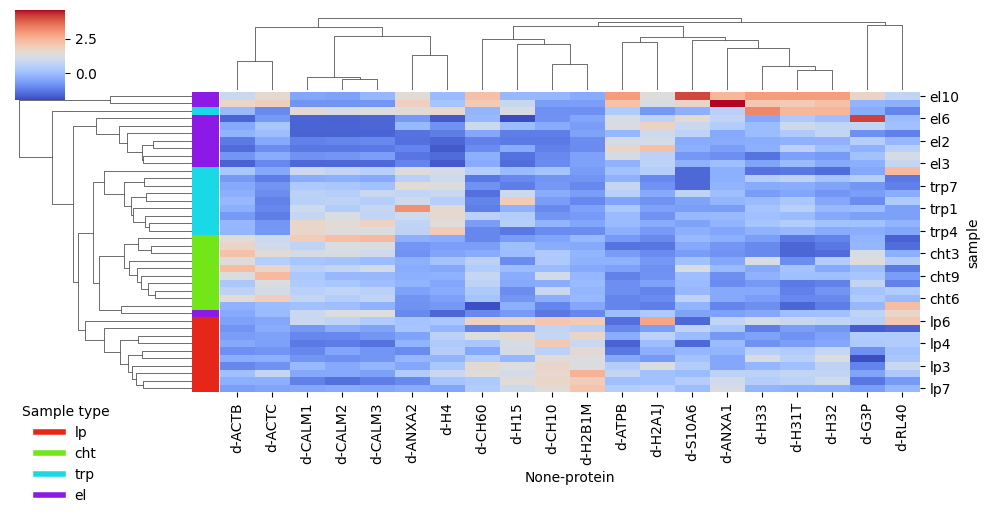

In [144]:
import seaborn as sns
import numpy as np

heatmap_df = results_df[["sample", "d", "protein"]]
heatmap_df = heatmap_df.pivot(columns="protein", index="sample")

g = sns.clustermap(
    heatmap_df,
    cmap="coolwarm",
    figsize=(10, 5),
    row_colors=row_colors.to_numpy(),
    z_score=True,

)

g.ax_heatmap.legend(
    frameon=False,
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(-0.3, 0),
    title="Sample type",
)

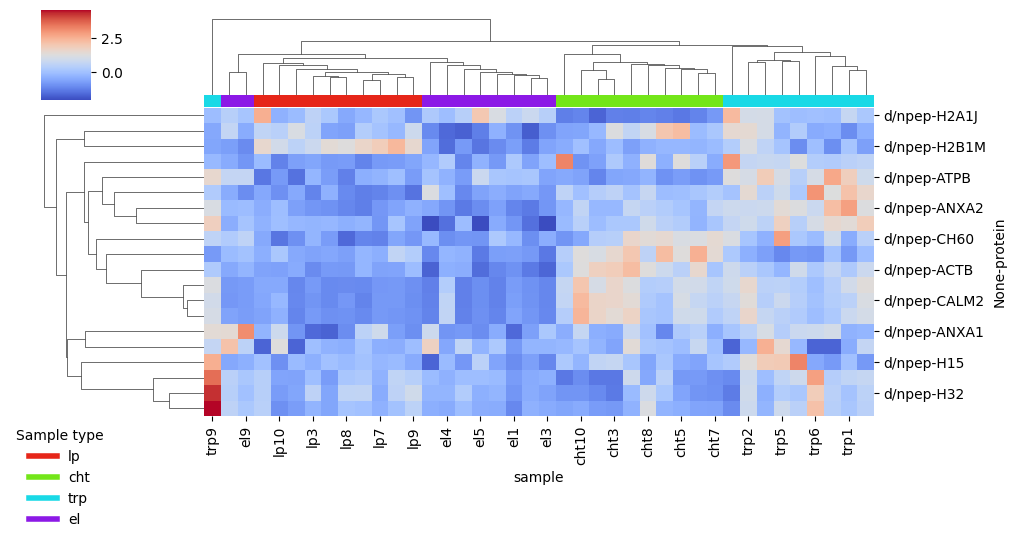

In [125]:

heatmap_df = results_df[["sample", "d/npep", "protein"]]
heatmap_df = heatmap_df.pivot(columns="protein", index="sample")

g = sns.clustermap(
    heatmap_df.T,
    cmap="coolwarm",
    figsize=(10, 5),
    col_colors=row_colors.to_numpy(),
    z_score=False,
)

g.ax_heatmap.legend(
    frameon=False,
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(-0.3, 0),
    title="Sample type",
)

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3398: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3398: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3398: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


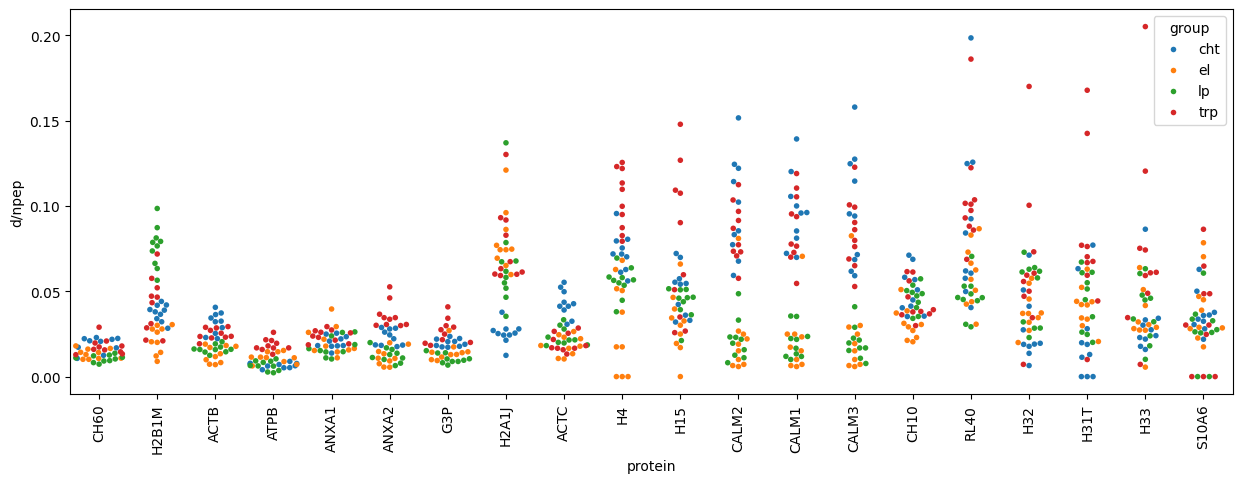

In [139]:

plt.figure(figsize=(15,5))
sns.swarmplot(
    results_df, x="protein", y="d/npep", hue="group", s=4
)
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='Density', ylabel='d/npep'>

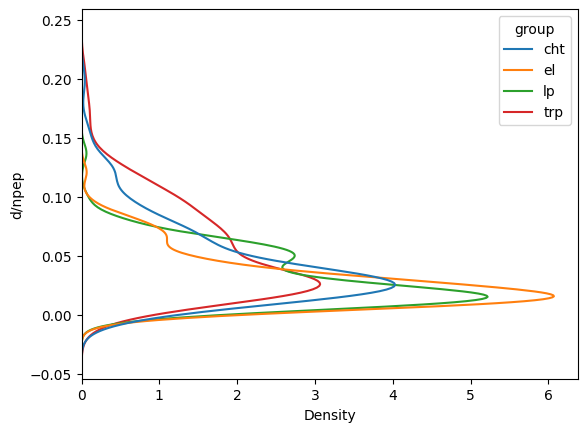

In [143]:
sns.kdeplot(results_df, y="d/npep", hue="group")